<a href="https://colab.research.google.com/github/tanyazyabkina/2015/blob/master/Impact_of_Targeting_Low_Churn_Prospects_Using_Raw_Counts_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation of How Change in Acquisition Targeting Impacts Financials
by Tanya Zyabkina

Input variables:
- Expected customer connects at the start point, loyalists and switchers
- Expected connects after the targeting change is implemented, loyalists and switchers
- Expected monthly churn rates for loyalists and switchers
- Simulation horizon, months

Assumptions:
- Average MRR per customer is $100 per month
- Stable base of 72,500 customers
- Monthly disconnects are 2,000 and they are equal to connects.  Monthly churn rate of 2.76%.
- Monthly churn rate of loyal customers is stable at 1.6% and switchers at 10%.
- Simulation starts at an equilibrium state, when connects are equal to disconnects, and the subscriber base is stable.
- The simulation changes the composition of new connects in terms of low and high switch propensity.
- Simulated connects are drawn from a normal distribution with the mean of the expected value after the change and a standard deviation of 5% of that value.
- Simulated disconnects are calculated from the previous month customer base for the segment and churn rate, which is drawn  drawn from a normal distribution with the mean of the expected churn rate for the segment and a standard deviation of 5% of that value.
- Customer Acquisition Cost (CAC) is expressed in average Monthly Recurring Revenue (MRR) and individual simulations are run for CAC between 3 and 5.5.
- Gross margin (GM) is expressed as a percent of revenue and individual simulations are run for GM between between 15% and 80%.
- EBITDA is the main profitability measure. It is defined as Gross Margin for all subscribers at the end of the month less Customer Acquisition Cost for connects for the month. It is expressed in MRR terms, i.e. to get your actual EBITDA for the month, multiply the number my your MRR.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Input variables

start_connects_loyalists = 1000
start_connects_switchers = 1000

end_connects_loyalists = 1200
end_connects_switchers = 700

churn_loyalists = 0.016
churn_switchers = 0.10

mrr = 100

planning_mo = 120

loyalists_subs_start = start_connects_loyalists/churn_loyalists
switchers_subs_start = start_connects_switchers/churn_switchers

start_percent_loyalists =  start_connects_loyalists/(start_connects_loyalists+start_connects_switchers)
end_percent_loyalists =  end_connects_loyalists/(end_connects_loyalists+end_connects_switchers)
start_percent_loyalists, end_percent_loyalists

(0.5, 0.631578947368421)

In [3]:
loyalists_subs_start, switchers_subs_start

(62500.0, 10000.0)

**Dimensions and Randomized Variables**

Simulation Inputs

In [50]:
gross_margin = np.arange(0.2, 0.80, 0.1) # percent gross margin
CAC_MRR = np.arange(3, 6, 0.5) # Cost of Acquisition of individual customer relvaive to MRR (i.e. $300 to $600)
#start_percent_loyalists = np.arange(0.3, 0.6, 0.05) # not used
#end_percent_loyalists = np.arange(0.4, 0.7, 0.05) # not used
sample_size = 100
input_size = len(gross_margin), len(CAC_MRR), sample_size, planning_mo

input_size_0 = [len(gross_margin), len(CAC_MRR), sample_size, 0]
input_size_1 = [len(gross_margin), len(CAC_MRR), sample_size, 1]
print(input_size_0)
print(input_size_1)

[7, 6, 100, 0]
[7, 6, 100, 1]


Churn simulations

In [51]:
loyalist_churn_mo = np.random.normal(churn_loyalists, churn_loyalists*0.05, size = input_size)
switcher_churn_mo = np.random.normal(churn_switchers, churn_switchers*0.05, size = input_size)
loyalist_connects_mo = np.random.normal(end_connects_loyalists, end_connects_loyalists*0.05, size = input_size)
switcher_connects_mo = np.random.normal(end_connects_switchers, end_connects_switchers*0.05, size = input_size)

Simulations

In [53]:
loyalists_subs_mo = np.empty(shape = input_size_0)
switchers_subs_mo = np.empty(shape = input_size_0)
loyalists_disc_mo = np.empty(shape = input_size_0)
switchers_disc_mo = np.empty(shape = input_size_0)
for mo in range(planning_mo):
    if mo == 0:
        l_disconnects = loyalists_subs_start*loyalist_churn_mo[:,:,:, mo]
        s_disconnects = switchers_subs_start*switcher_churn_mo[:,:,:, mo]
        loyalists_eom = loyalists_subs_start + loyalist_connects_mo[:,:,:, mo] - l_disconnects
        switchers_eom = switchers_subs_start + switcher_connects_mo[:,:,:, mo] - s_disconnects
    else:
        l_disconnects = loyalists_subs_mo[:,:,:, mo-1]*loyalist_churn_mo[:,:,:, mo]
        s_disconnects = switchers_subs_mo[:,:,:, mo-1]*switcher_churn_mo[:,:,:, mo]
        loyalists_eom = loyalists_subs_mo[:,:,:, mo-1] + loyalist_connects_mo[:,:,:, mo] - l_disconnects
        switchers_eom = switchers_subs_mo[:,:,:, mo-1] + switcher_connects_mo[:,:,:, mo] - s_disconnects


    loyalists_disc_mo = np.append(loyalists_disc_mo, l_disconnects.reshape(input_size_1), axis = 3) # check the logic on the axis
    switchers_disc_mo = np.append(switchers_disc_mo, s_disconnects.reshape(input_size_1), axis = 3)
    loyalists_subs_mo = np.append(loyalists_subs_mo, loyalists_eom.reshape(input_size_1), axis = 3)
    switchers_subs_mo = np.append(switchers_subs_mo, switchers_eom.reshape(input_size_1), axis = 3)


In [56]:
# calculate metrics
total_subs_mo = loyalists_subs_mo + switchers_subs_mo
total_disc_mo = loyalists_disc_mo + switchers_disc_mo
total_connects_mo = loyalist_connects_mo + switcher_connects_mo

churn_rate_mo = total_disc_mo/total_subs_mo
tenure_disc = 1/churn_rate_mo
reduction_churn = 1 - churn_rate_mo[:,:,:, 1:]/((start_connects_loyalists+start_connects_switchers)/
                                                    (loyalists_subs_start+switchers_subs_start))

# $ total monthly gross margin
gmargin = total_subs_mo*mrr*gross_margin.reshape(len(gross_margin),1,1,1) # gross_margin is a 1D array of gms used for simulation
cac_mo = total_connects_mo*mrr*CAC_MRR.reshape(1,len(CAC_MRR),1,1)
ebitda_mo = gmargin - cac_mo
ebitda_change = ebitda_mo[:,:,:, 1:]/ebitda_mo[:,:,:, 0].reshape(input_size_1) - 1
gmargin_change = gmargin[:,:,:, 1:]/gmargin[:,:,:, 0].reshape(input_size_1) - 1

ind_gm_in_mo = tenure_disc*mrr*gross_margin.reshape(len(gross_margin),1,1,1)
clv_in_mo = ind_gm_in_mo - CAC_MRR.reshape(1,len(CAC_MRR),1,1)*mrr
clv_change = clv_in_mo[:,:,:, 1:]/clv_in_mo[:,:,:, 0].reshape(input_size_1) - 1


In [59]:
ebitda_mo[6, 5, 1,:][:20]

array([4668715.70399036, 4767641.11700246, 4767132.2686167 ,
       4765603.03628319, 4698917.93718126, 4678665.34352299,
       4749972.93543652, 4758771.72924238, 4803465.76136323,
       4738178.69254104, 4772109.19466452, 4770813.71320421,
       4798893.01525647, 4770553.57073481, 4781763.6063446 ,
       4814897.84625612, 4879294.51650713, 4802737.67578575,
       4868902.25059834, 4810563.93359292])

In [60]:
CAC_MRR*mrr
# Cost of Acquiring a new customer

array([300., 350., 400., 450., 500., 550.])

''

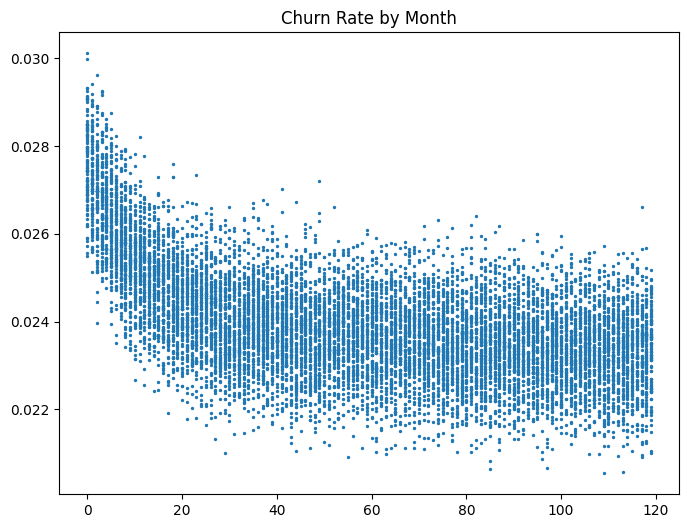

In [61]:
plt.figure(figsize = (8,6))
plt.scatter(y = np.transpose(churn_rate_mo[1, 1, :, :]),
            x = np.transpose(np.tile(range(planning_mo), 100).reshape(100, planning_mo)),
            s = 2)
plt.title('Churn Rate by Month')
;


''

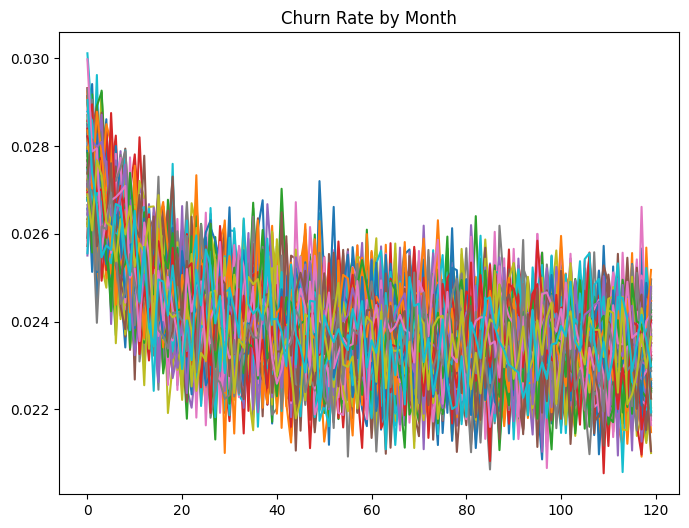

In [62]:
plt.figure(figsize = (8,6))
plt.plot(np.transpose(churn_rate_mo[ 1, 1, :, :]))
plt.title('Churn Rate by Month')
;

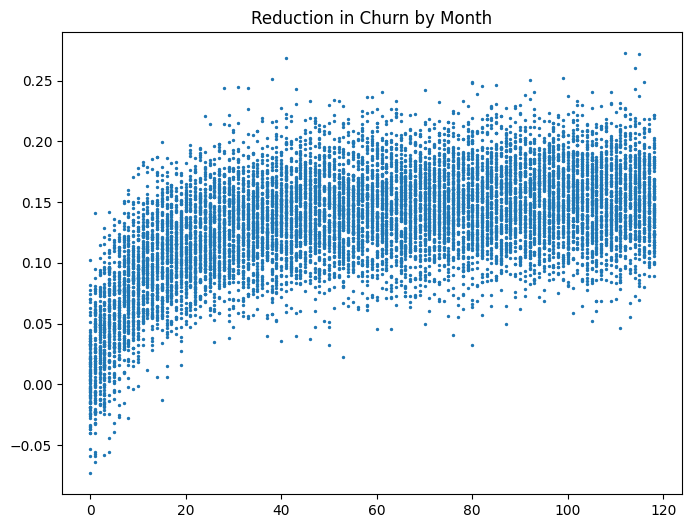

In [63]:
plt.figure(figsize = (8,6))
plt.scatter(y = np.transpose(reduction_churn[ 5, 1, :, :]),
            x = np.transpose(np.tile(range(planning_mo-1), 100).reshape(100, planning_mo-1)),
            s = 2)
plt.title('Reduction in Churn by Month') ;

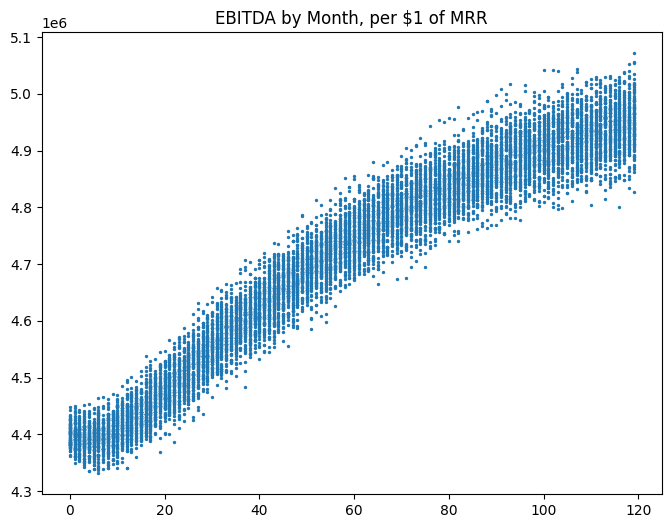

In [64]:
plt.figure(figsize = (8,6))
plt.scatter(y = np.transpose(ebitda_mo[5, 1, :, :]),
            x = np.transpose(np.tile(range(planning_mo), 100).reshape(100, planning_mo)),
            s = 2)
plt.title('EBITDA by Month, per $1 of MRR') ;

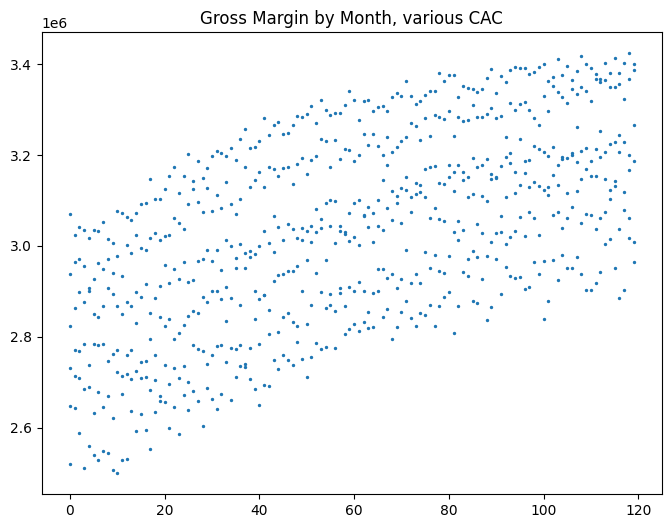

In [65]:
plt.figure(figsize = (8,6))
plt.scatter(y = np.transpose(ebitda_mo[3, :, 10, :]),
            x = np.transpose(np.tile(range(planning_mo), 6).reshape(6, planning_mo)),
            s = 2)
plt.title('Gross Margin by Month, various CAC');

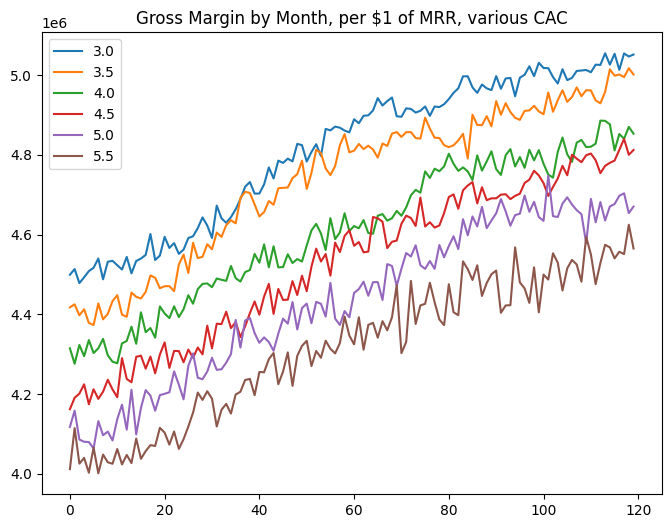

In [66]:
plt.figure(figsize = (8,6))
plt.plot(np.transpose(ebitda_mo[5, :, 12, :]))
plt.title('Gross Margin by Month, per $1 of MRR, various CAC')
plt.legend(CAC_MRR);

In [31]:
np.transpose(gmargin[0, 0, 1, :, 10, :]).shape

(120, 6)

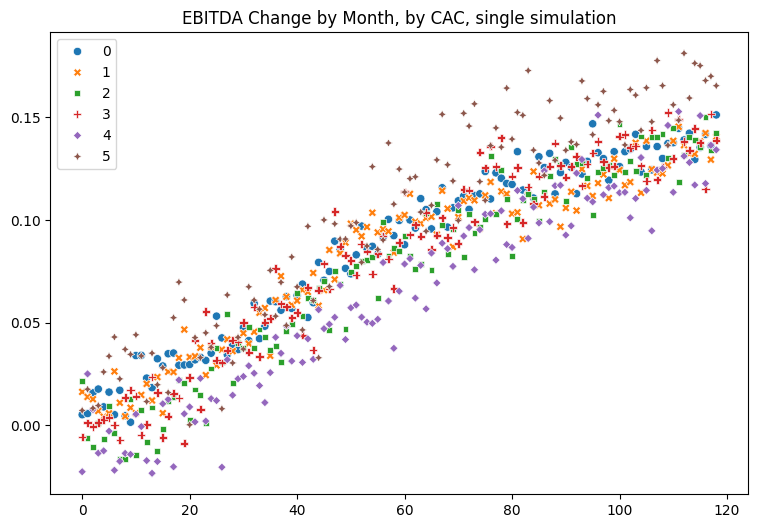

In [67]:
plt.figure(figsize = (9,6))
sns.scatterplot(data=np.transpose(ebitda_change[3, :, 15, :]))
plt.title('EBITDA Change by Month, by CAC, single simulation');

**Decrease in churn and margin change**

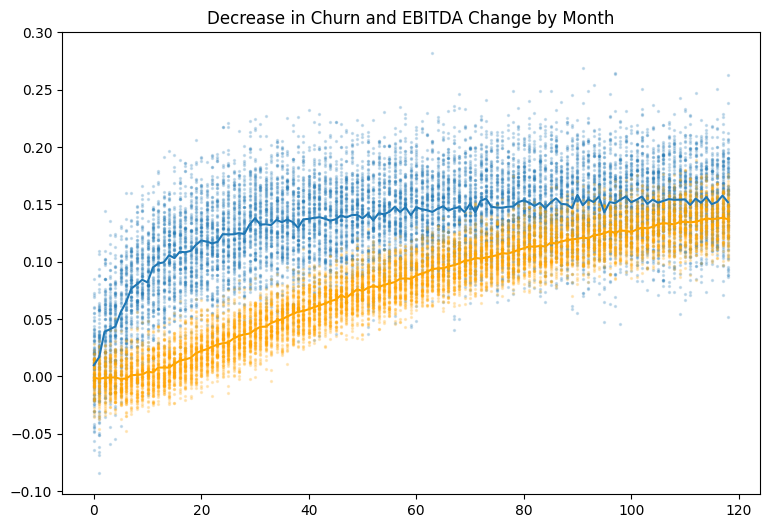

In [68]:
gm_cat = 4
cac_cat = 4

plt.figure(figsize = (9,6))
plt.scatter(y = np.transpose(reduction_churn[gm_cat, cac_cat, :, :]),
            x = np.transpose(np.tile(range(planning_mo-1), 100).reshape(100, planning_mo-1)),
            s = 2, alpha=0.2)

plt.scatter(y = np.transpose(ebitda_change[gm_cat, cac_cat, :, :]),
            x = np.transpose(np.tile(range(planning_mo-1), 100).reshape(100, planning_mo-1)),
            s = 2, color = 'orange', alpha=0.2)
plt.plot(np.nanmean(reduction_churn[gm_cat, cac_cat, :, :], axis=0))
plt.plot(np.nanmean(ebitda_change[gm_cat, cac_cat, :, :], axis=0), color = 'orange')
plt.title('Decrease in Churn and EBITDA Change by Month');

**Churn Decline vs Margin Change**

In [ ]:
CAC_MRR*mrr

array([300., 350., 400., 450., 500., 550.])

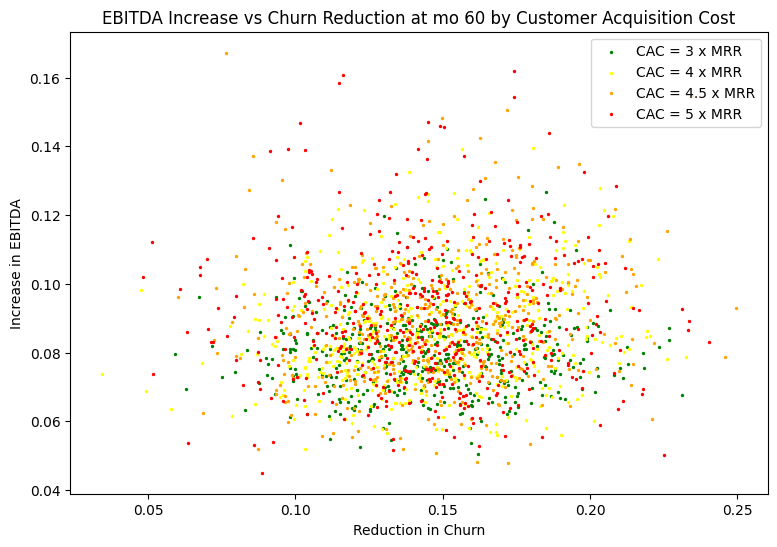

In [69]:
gm_cat = 7
cac_cat = 4
mo = 60

plt.figure(figsize = (9,6))
plt.scatter(y = np.transpose(ebitda_change[2:, 0, :, mo]),
            x = np.transpose(reduction_churn[2:, 0, :, mo]),
            s = 2, color = 'green')
plt.scatter(y = np.transpose(ebitda_change[2:, 2, :, mo]),
            x = np.transpose(reduction_churn[2:, 2, :, mo]),
            s = 2, color = 'yellow')
plt.scatter(y = np.transpose(ebitda_change[2:, 3, :, mo]),
            x = np.transpose(reduction_churn[2:, 3, :, mo]),
            s = 2, color = 'orange')
plt.scatter(y = np.transpose(ebitda_change[2:, 4, :, mo]),
            x = np.transpose(reduction_churn[2:, 4, :, mo]),
            s = 2, color = 'red')
plt.legend(labels = ['CAC = 3 x MRR', 'CAC = 4 x MRR', 'CAC = 4.5 x MRR', 'CAC = 5 x MRR'])
plt.title('EBITDA Increase vs Churn Reduction at mo '+ str(mo) + ' by Customer Acquisition Cost')
plt.xlabel('Reduction in Churn')
plt.ylabel('Increase in EBITDA');

In [ ]:
gross_margin[13]

0.8000000000000003

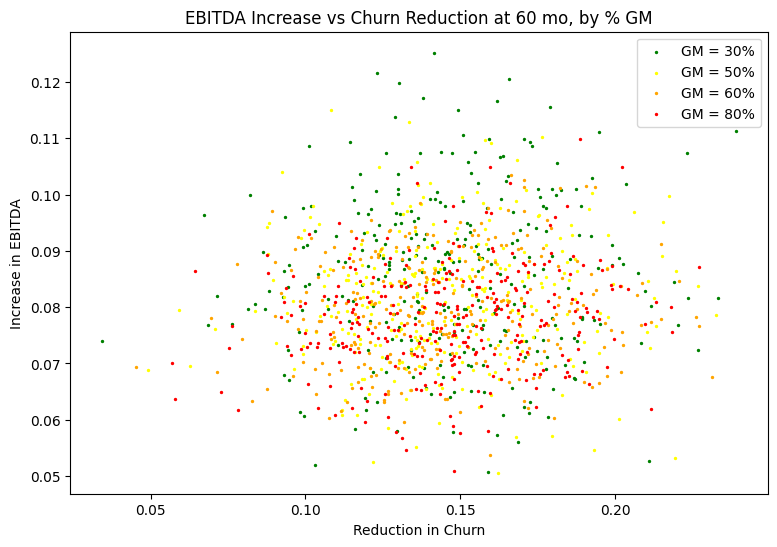

In [71]:
plt.figure(figsize = (9,6))
plt.scatter(y = np.transpose(ebitda_change[3, :3, :, mo]),
            x = np.transpose(reduction_churn[3, :3, :, mo]),
            s = 2, color = 'green')
plt.scatter(y = np.transpose(ebitda_change[4, :3, :, mo]),
            x = np.transpose(reduction_churn[4, :3, :, mo]),
            s = 2, color = 'yellow')
plt.scatter(y = np.transpose(ebitda_change[5, :3, :, mo]),
            x = np.transpose(reduction_churn[5, :3, :, mo]),
            s = 2, color = 'orange')
plt.scatter(y = np.transpose(ebitda_change[6, :3, :, mo]),
            x = np.transpose(reduction_churn[6, :3, :, mo]),
            s = 2, color = 'red')
plt.legend(labels = ['GM = 30%', 'GM = 50%', 'GM = 60%', 'GM = 80%'])
plt.title('EBITDA Increase vs Churn Reduction at '+ str(mo) + ' mo, by % GM')
plt.xlabel('Reduction in Churn')
plt.ylabel('Increase in EBITDA');

In [36]:
np.transpose(np.tile(CAC_MRR.reshape(6,1), 100)).shape

(100, 6)

**Cost of Acquisition and Margin Change at 24 Months**

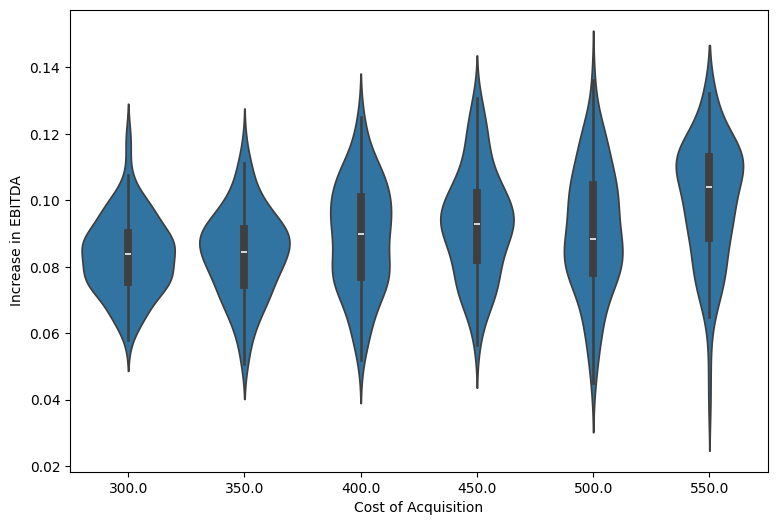

In [73]:
plt.figure(figsize = (9,6))
sns.violinplot(y=ebitda_change[3, :, :, mo].flatten(),
              x = np.tile(CAC_MRR.reshape(6,1)*100, 100).flatten())
plt.xlabel('Cost of Acquisition')
plt.ylabel('Increase in EBITDA');

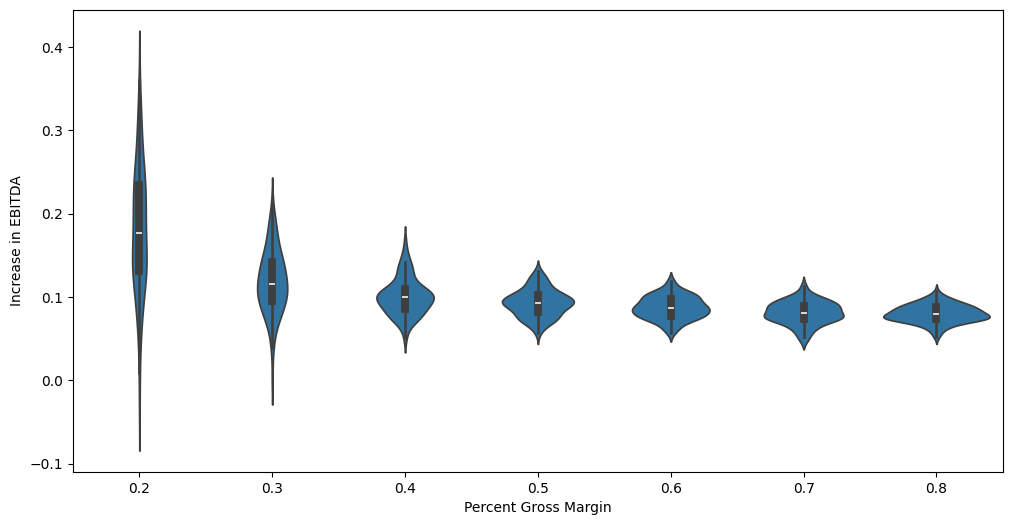

In [74]:
plt.figure(figsize = (12,6))
sns.violinplot(y = ebitda_change[:, 3, :, mo].flatten(),
              x = np.tile(np.round(gross_margin, 2).reshape(len(gross_margin),1), 100).flatten())
plt.xlabel('Percent Gross Margin')
plt.ylabel('Increase in EBITDA');

In [75]:
np.tile(gross_margin.reshape(len(gross_margin),1), 100).flatten()

array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.

In [76]:
np.round(gross_margin, 2)

array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

In [78]:
gmargin[1, cac_cat, 25, :]

array([2170881.7259126 , 2167061.76072074, 2165050.07880162,
       2163964.67478886, 2161520.05446859, 2164565.81627103,
       2164015.16377672, 2165214.29203751, 2168751.72574303,
       2174480.98110273, 2178296.62590656, 2180488.9399262 ,
       2182872.11116712, 2182140.12425143, 2182840.39111415,
       2188158.93910593, 2192426.01970639, 2194769.21629676,
       2200083.14515709, 2204910.50928131, 2214101.46173761,
       2218608.73731541, 2223101.37351059, 2221937.4693181 ,
       2222388.76284329, 2227346.62129109, 2228983.6109809 ,
       2234342.7568818 , 2238832.86381572, 2241173.68696747,
       2247198.23621213, 2246918.42528202, 2252351.08812016,
       2252598.65150522, 2254331.35443922, 2256943.95196015,
       2259128.11343693, 2260039.04426627, 2262523.59581109,
       2262845.02196713, 2267143.52965278, 2265234.83775229,
       2270950.93635249, 2278980.10424255, 2279260.4642013 ,
       2278284.0470846 , 2276660.53169505, 2277738.5072533 ,
       2284004.70245483,

In [79]:
gmargin_change[0, cac_cat, 23, :]

array([-5.49274728e-04,  4.13329255e-04, -3.04726249e-05,  1.38076219e-03,
        2.76005590e-03,  2.84005707e-03,  4.88703753e-03,  3.28657939e-03,
        4.05909453e-03,  2.98966013e-03,  3.17107862e-03,  3.35865401e-03,
        2.40259396e-03,  1.17590878e-03,  2.40964696e-03,  2.75509700e-03,
        4.93480174e-03,  6.25956244e-03,  9.27270310e-03,  1.10216767e-02,
        1.11747607e-02,  1.45694152e-02,  1.65332332e-02,  1.81343928e-02,
        1.87828811e-02,  1.99082042e-02,  2.49368302e-02,  2.68978735e-02,
        2.66923338e-02,  2.86734105e-02,  3.03814085e-02,  3.15279399e-02,
        3.38697646e-02,  3.49917117e-02,  3.57190113e-02,  3.42073643e-02,
        3.65650135e-02,  3.85993051e-02,  4.12686983e-02,  4.37751792e-02,
        4.63540411e-02,  4.67697343e-02,  4.63796019e-02,  4.94995641e-02,
        5.19288894e-02,  5.30131609e-02,  5.30765396e-02,  5.43451627e-02,
        5.49515382e-02,  5.56744830e-02,  5.46324270e-02,  5.46978343e-02,
        5.50692809e-02,  

In [45]:
np.nanmean(gmargin_change[0, 0, gm_cat, cac_cat, :, :], axis=0)[11]

np.float64(0.0034047225758291498)

In [ ]:
np.nanmean(reduction_churn[0, 1, gm_cat, cac_cat, :, :], axis=0)[11]

In [ ]:
np.nanmean(margin_per_mrr[0, 1, gm_cat, cac_cat, :, :], axis=0)[11]

In [ ]:
plt.plot(np.nanmean(reduction_churn[0, 1, 5, 3, :, :], axis=0))

In [47]:
gmargin

array([[[[[[1084073.50958582, 1081862.07781674, 1082108.79783414,
            ..., 1189537.60050192, 1193529.57028948,
            1195202.35249514],
           [1086833.37045773, 1085872.64484103, 1085033.12461422,
            ..., 1207066.41636222, 1208111.29038924,
            1208060.36687357],
           [1086536.80921939, 1084378.48998169, 1082822.10888427,
            ..., 1202599.77851941, 1206597.52478227,
            1206113.81873194],
           ...,
           [1086101.75462945, 1084471.98756384, 1085191.25057073,
            ..., 1209289.13699396, 1209469.41556855,
            1209216.77390545],
           [1084204.82133642, 1083135.87558635, 1083798.31585722,
            ..., 1205700.17988575, 1206726.8164963 ,
            1207050.90773285],
           [1087226.93378118, 1084834.69044887, 1082812.43675347,
            ..., 1208025.50731877, 1210172.84347849,
            1213118.65732667]],

          [[1086948.65492218, 1085698.82993178, 1087071.29144433,
            ...,

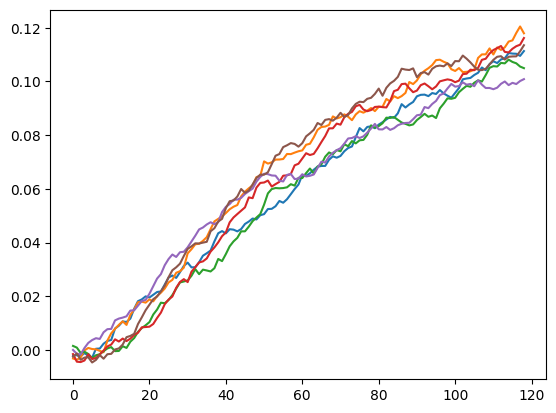

In [80]:
plt.plot(np.transpose(gmargin_change[1, :, 10, :]));

In [48]:
gmargin[0, 0, 1, :, 10, 0]

array([1451044.37471482, 1448842.28072018, 1447503.93522748,
       1443476.037095  , 1447476.13116716, 1451099.6290229 ])